In [1]:
"""
ACMS 80770-03: Deep Learning with Graphs
Instructor: Navid Shervani-Tabar
Fall 2022
University of Notre Dame

Homework 2: Programming assignment
Problem 1
"""
import torch
from torch import nn
import warnings
import numpy as np

import itertools
warnings.simplefilter(action='ignore', category=UserWarning)
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor


"""
    load data
"""
dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 5000, False))

V = 9
atom_types = [6, 8, 7, 9, 1]

def adj(x):
    x = x[1]
    adjacency = np.zeros((V, V)).astype(float)
    adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
    return torch.tensor(adjacency)


def sig(x):
    x = x[0]
    atoms = np.ones((V)).astype(float)
    atoms[:len(x)] = x
    out = np.array([int(atom == atom_type) for atom_type in atom_types for atom in atoms]).astype(float)
    return torch.tensor(out).reshape(5, len(atoms)).T


def target(x):
    x = x[2]
    return torch.tensor(x)


adjs = torch.stack(list(map(adj, dataset)))
sigs = torch.stack(list(map(sig, dataset)))
prop = torch.stack(list(map(target, dataset)))[:, 5]

100%|██████████████████████████████████████| 5000/5000 [00:21<00:00, 233.30it/s]


In [2]:
for _ in adjs:
    _.fill_diagonal_(1)

In [3]:
class GCN:
    """
        Graph convolutional layer
    """
    def __init__(self, in_features, out_features):
        # -- initialize weight
        #self.weight = torch.tensor(torch.normal(mean=torch.zeros((in_features,out_features)), std=torch.ones((in_features,out_features))))
        self.weight = torch.empty(in_features, out_features)
        nn.init.xavier_normal_(self.weight)
        self.weight = self.weight.double().requires_grad_()
        # -- non-linearity
        self.f = nn.ReLU()

    def __call__(self, A, H):
        #degree calculation, sum A and convert each row into a diagonal matrix
        a = torch.sum(A, 1)
        a = 1./a #inverse
        b = torch.eye(a.size(1))
        c = a.unsqueeze(2).expand(*a.size(), a.size(1))
        degree = c * b
        res = torch.matmul(degree, A)
        res = torch.matmul(res, degree)
        res = torch.matmul(res, H)
        res = torch.matmul(res, self.weight.to(torch.float64))
        return self.f(res)

class GraphPooling:
    """
        Graph pooling layer
    """
    def __init__(self):
        pass

    def __call__(self, H):
        # -- multi-set pooling operator
        return torch.sum(H, dim=1)


class MyModel(nn.Module):
    """
        Regression  model
    """
    def __init__(self):
        super(MyModel, self).__init__()
        # -- initialize layers
        self.GCN = GCN(5,3)
        self.GraphPooling = GraphPooling()
        #self.act1 = nn.ReLU()
        #self.batchnorm = nn.BatchNorm1d(3)
        self.FNN1 = nn.Linear(3, 2)
        self.act2 = nn.ReLU()
        self.FNN2 = nn.Linear(2, 1)
        

    def forward(self, A, h0):
        hnext = self.GCN.__call__(A, h0)
        hagg = self.GraphPooling.__call__(hnext).to(torch.float32)
        #hagg = self.act1(hagg)
        #hagg = self.batchnorm(hagg)
        hF1 = self.FNN1(hagg)
        hF1 = self.act2(hF1)
        hF2 = self.FNN2(hF1)
        return hF2

In [4]:
model = MyModel()
prop_min = torch.min(prop)
prop_max = torch.max(prop)
prop_norm = (prop_max-prop)/(prop_max-prop_min)

In [ ]:
print(model)

In [5]:
"""
    Train
"""
# -- Initialize the model, loss function, and the optimizer
#model = MyModel()
losstrack = []
MyLoss = nn.MSELoss()
MyOptimizer = torch.optim.SGD(itertools.chain([model.GCN.weight], model.parameters()), lr=0.1)
running_loss = 0
# -- update parameters
for epoch in range(200):
    for i in range(200):
        MyOptimizer.zero_grad()

        # -- predict
        pred = model(adjs[i*25:(i+1)*25], sigs[i*25:(i+1)*25])
        #print(pred)

        # -- loss
        loss = MyLoss(pred, prop[i*25:(i+1)*25])

        # Make predictions for this batch

        # Compute the loss and its gradients
        
        loss.backward()

        # Adjust learning weights
        MyOptimizer.step()

        # -- optimize
    losstrack.append(loss.item())
    print(loss.item())

# -- plot loss

0.0005205291672609746
0.0005057906382717192
0.000489093130454421
0.0004766502243001014
0.00046749049215577543
0.00046064890921115875
0.0004554694169200957
0.0004515002656262368
0.0004484041128307581
0.00044600333785638213
0.00044418679317459464
0.000442740973085165
0.000441579963080585
0.0004406577500049025
0.00043992060818709433
0.0004393147537484765
0.0004388125380501151
0.00043839288991875947
0.00043803901644423604
0.00043773860670626163
0.0004374815907794982
0.00043726013973355293
0.0004370681708678603
0.0004369004163891077
0.0004367530345916748
0.0004366228240542114
0.00043650722363963723
0.0004364039341453463
0.00043631138396449387
0.0004362280305940658
0.0004361529427114874
0.000436084606917575
0.00043602162622846663
0.0004359640006441623
0.0004359113227110356
0.00043586312676779926
0.00043581885984167457
0.00043577858014032245
0.00043574252049438655
0.00043570937123149633
0.000435678637586534
0.0004356505523901433
0.0004356252611614764
0.00043560200720094144
0.00043558006291277

In [8]:
testset, testset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 1000, False))

test_adjs = torch.stack(list(map(adj, testset)))
test_sigs = torch.stack(list(map(sig, testset)))
test_prop = torch.stack(list(map(target, testset)))[:, 5]

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 236.44it/s]


In [9]:
for _ in test_adjs:
    _.fill_diagonal_(1)

In [10]:
#y_pred = prop_max-model(test_adjs, test_sigs)*(prop_max-prop_min)

y_pred = model(test_adjs, test_sigs)
#y_pred = prop_max-model(test_adjs, test_sigs)*(prop_max-prop_min)

Text(0, 0.5, 'Prediction')

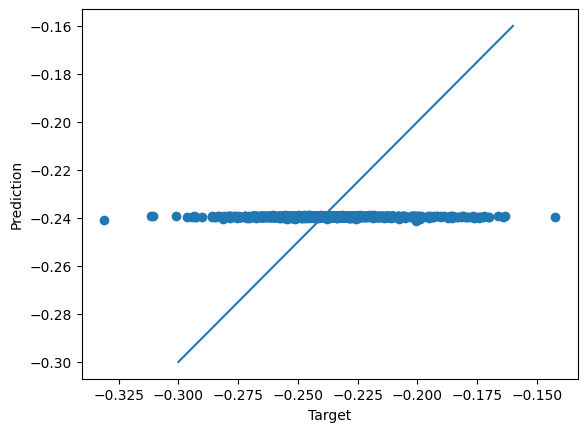

In [13]:
plt.scatter(test_prop.tolist(), y_pred[:,0].tolist())
plt.plot(np.linspace(-0.3, -0.16, 1000), np.linspace(-0.3, -0.16, 1000))
#plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000))
plt.xlabel("Target")
plt.ylabel("Prediction")

In [6]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'error')

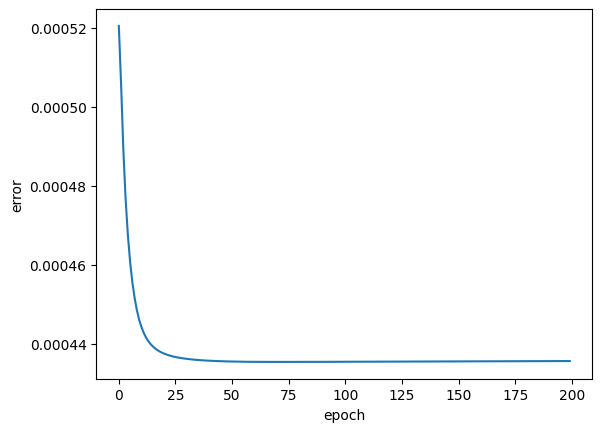

In [7]:
plt.plot(range(200),losstrack)
plt.xlabel("epoch")
plt.ylabel("error")